<a href="https://colab.research.google.com/github/RiddhiTripathi/PySpark/blob/main/EDA_with_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3a20b30433d3d0cde7dec431049c516420a168e6e9bff6844d2c0839d63a8a0e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
pip install findspark

In [4]:
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt


In [5]:
spark = SparkSession.builder.appName("firstSparkProject").getOrCreate()

In [6]:
def load_dataframe(filename):
  df = spark.read.format('csv').options(header='true').load(filename)
  return df

df_matches = load_dataframe('/content/pyspark_data_files/Matches.csv')
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



##### Converting the column names to make it readable

In [7]:
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]
old_new_cols = [*zip(old_cols,new_cols)]
for old_col,new_col in old_new_cols:
  df_matches = df_matches.withColumnRenamed(old_col,new_col)

df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


### Who are the winners of D1 division in the Germany Football Association(Bundesliga) between 2000 -2010?

In [8]:
df_matches = df_matches.withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0))\
                       .withColumn('AwayTeamWin',when(col('FinalResult') == 'A', 1).otherwise(0))\
                       .withColumn('GameTie', when(col('FinalResult') == 'D' ,1).otherwise(0))

bundesliga = df_matches \
                      .filter((col('Season') >= 2000) &
                              (col('Season') <= 2010) &
                              (col('Div') == 'D1'))

home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

In [9]:
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())

In [10]:
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window))

In [11]:
table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()


In [12]:
table_df

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Bayern Munich,2000,62.0,37.0,25.0,19,9,6,55.88,1
1,Leverkusen,2001,77.0,38.0,39.0,21,7,6,61.76,1
2,Bayern Munich,2002,70.0,25.0,45.0,23,5,6,67.65,1
3,Werder Bremen,2003,79.0,38.0,41.0,22,4,8,64.71,1
4,Bayern Munich,2004,75.0,33.0,42.0,24,5,5,70.59,1
5,Bayern Munich,2005,67.0,32.0,35.0,22,3,9,64.71,1
6,Stuttgart,2006,61.0,37.0,24.0,21,6,7,61.76,1
7,Bayern Munich,2007,68.0,21.0,47.0,22,2,10,64.71,1
8,Wolfsburg,2008,80.0,41.0,39.0,21,7,6,61.76,1
9,Bayern Munich,2009,72.0,31.0,41.0,20,4,10,58.82,1


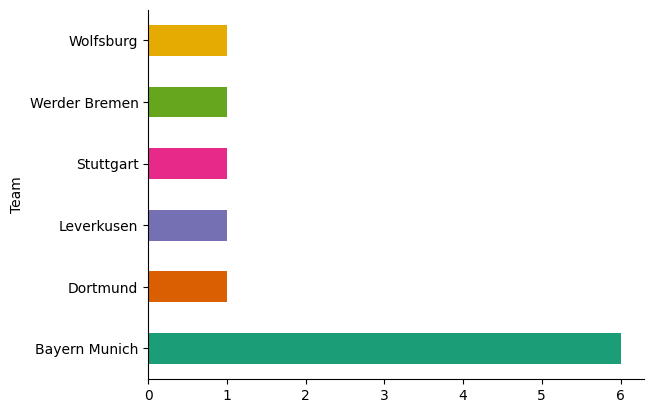

In [15]:
# @title Team

from matplotlib import pyplot as plt
import seaborn as sns
table_df.groupby('Team').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
table.groupby('Team').agg(count('Team').alias("TotalChampionships"),
                          avg('WinPct').alias('AvgWinPct'),
                          avg('GoalDifferentials').alias('AvgGD'),
                          avg('Win').alias('AvgWin'),
                          avg('Loss').alias('AvgLoss'),
                          avg('Tie').alias('AvgTie')) \
    .orderBy(desc("TotalChampionships")).toPandas().round(1)

,Team,TotalChampionships,AvgWinPct,AvgGD,AvgWin,AvgLoss,AvgTie
0,Schalke 04,11,48.1,14.3,16.4,9.2,8.5
1,Werder Bremen,11,50.3,20.7,17.1,9.7,7.2
2,Leverkusen,11,47.3,17.8,16.1,10.0,7.9
3,Hamburg,11,41.2,5.2,14.0,10.9,9.1
4,Wolfsburg,11,37.4,3.2,12.7,13.0,8.3
5,Stuttgart,11,44.4,9.6,15.1,10.1,8.8
6,Bayern Munich,11,60.7,35.5,20.6,5.8,7.5
7,Dortmund,11,45.5,14.2,15.5,8.8,9.7
8,Hertha,10,40.0,2.8,13.6,12.1,8.3
9,Hannover,9,34.0,-9.0,11.6,13.9,8.6


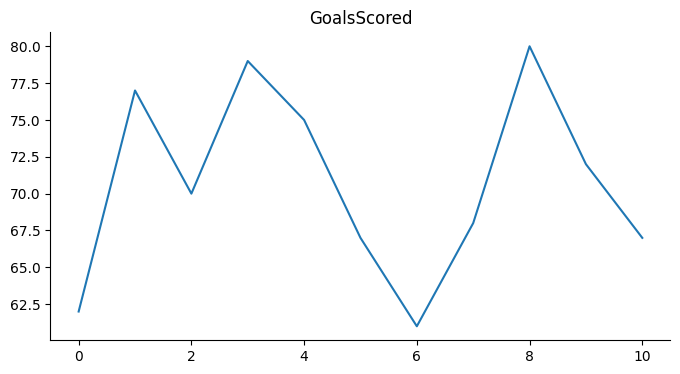

In [13]:
# @title GoalsScored

from matplotlib import pyplot as plt
table_df['GoalsScored'].plot(kind='line', figsize=(8, 4), title='GoalsScored')
plt.gca().spines[['top', 'right']].set_visible(False)